In [1]:
%%capture
!pip install bertopic datasets openai datamapplot

# **ag_news**

"""
AG News is a widely used text classification dataset consisting of news articles categorized into four classes:
World, Sports, Business, and Sci/Tech. Each sample includes a title and a short description of a news item.
The dataset contains 120,000 training samples and 7,600 test samples, making it suitable for evaluating
natural language processing models on multi-class text classification tasks.
"""


In [2]:
# Load data from huggingface
from datasets import load_dataset
dataset = load_dataset("ag_news")["train"]
abstracts = list(dataset["text"])
titles = list(dataset["label"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

# **A Common Pipeline for Text Clustering**

## **1. Embedding Documents**

In [3]:
from sentence_transformers import SentenceTransformer

# Create an embedding for each abstract
embedding_model = SentenceTransformer('thenlper/gte-small')
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [4]:
# Check the dimensions of the resulting embeddings
embeddings.shape

(120000, 384)

## **2. Reducing the Dimensionality of Embeddings**

In [5]:
from umap import UMAP

# We reduce the input embeddings from 384 dimenions to 5 dimenions
umap_model = UMAP(
    n_components=5, min_dist=0.0, metric='cosine', random_state=42
)
reduced_embeddings = umap_model.fit_transform(embeddings)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## **3. Cluster the Reduced Embeddings**

In [6]:
from hdbscan import HDBSCAN

# We fit the model and extract the clusters
hdbscan_model = HDBSCAN(
    min_cluster_size=1000, metric='euclidean', cluster_selection_method='eom'
).fit(reduced_embeddings)
clusters = hdbscan_model.labels_

# How many clusters did we generate?
len(set(clusters))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


23

## **Inspecting the Clusters**

Manually inspect the first three documents in cluster 0:

In [7]:
import numpy as np

# Print first three documents in cluster 0
cluster = 0
for index in np.where(clusters==cluster)[0][:3]:
    print(abstracts[index][:300] + "... \n")

Arsenal Beats Everton to Extend Streak (AP) AP - Arsenal opened its defense of its English title with a 4-1 win at Everton on Sunday, making it 41 straight games without a loss in the Premier League.... 

A bit of a head-scratcher In many professional leagues recently, the defending champion has had a smooth start to the season. Mexico proved to be an exception, though, as UNAM Pumas fell to Tecos, 1-0, losing two players and coach Hugo Sanchez to ejections Sunday.... 

India agree contracts India players agree central contracts for the first time, with top stars netting a basic salary of 59,000.... 



Next, we reduce our embeddings to 2-dimensions so that we can plot them and get a rough understanding of the generated clusters.

In [8]:
import pandas as pd

# Reduce 384-dimensional embeddings to 2 dimensions for easier visualization
reduced_embeddings = UMAP(
    n_components=2, min_dist=0.0, metric='cosine', random_state=42
).fit_transform(embeddings)

# Create dataframe
df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df["title"] = titles
df["cluster"] = [str(c) for c in clusters]

# Select outliers and non-outliers (clusters)
clusters_df = df.loc[df.cluster != "-1", :]
outliers_df = df.loc[df.cluster == "-1", :]

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### Static Plot

(np.float64(-13.147875452041626),
 np.float64(13.04138150215149),
 np.float64(-14.598810195922852),
 np.float64(19.583250045776367))

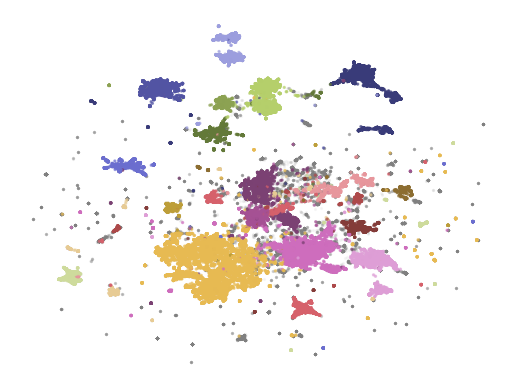

In [9]:
import matplotlib.pyplot as plt

# Plot outliers and non-outliers seperately
plt.scatter(outliers_df.x, outliers_df.y, alpha=0.05, s=2, c="grey")
plt.scatter(
    clusters_df.x, clusters_df.y, c=clusters_df.cluster.astype(int),
    alpha=0.6, s=2, cmap='tab20b'
)
plt.axis('off')
# plt.savefig("matplotlib.png", dpi=300)  # Uncomment to save the graph as a .png

# From Text Clustering to Topic Modeling

## **BERTopic: A Modular Topic Modeling Framework**

In [10]:
from bertopic import BERTopic

# Train our model with our previously defined models
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
).fit(abstracts, embeddings)

2025-07-30 12:37:56,430 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-30 12:41:09,839 - BERTopic - Dimensionality - Completed ✓
2025-07-30 12:41:09,844 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-30 12:41:50,253 - BERTopic - Cluster - Completed ✓
2025-07-30 12:41:50,304 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-30 12:41:53,176 - BERTopic - Representation - Completed ✓


Now, let's start exploring the topics that we got by running the code above.

In [11]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,27517,-1_the_to_of_in,"[the, to, of, in, on, and, for, 39, that, said]",[Europe Is Said to Be Close to Allowing Bid by...
1,0,20452,0_to_the_and_of,"[to, the, and, of, microsoft, its, for, new, t...",[Yahoo! takes a partner for desktop-search fra...
2,1,8733,1_stocks_profit_reuters_and,"[stocks, profit, reuters, and, the, to, on, fu...",[Dow Ends Up on J J Deal NEW YORK (Reuters) -...
3,2,7486,2_the_ap_to_no,"[the, ap, to, no, for, game, and, in, coach, s...",[Little Movement in AP Football Poll (AP) AP -...
4,3,5828,3_of_the_to_drug,"[of, the, to, drug, in, and, that, on, scienti...","[Pfizer, AstraZeneca Pummel Drug Stocks Anothe..."
5,4,5751,4_the_39_to_england,"[the, 39, to, england, champions, in, league, ...",[Owen Scores as Real Madrid Wins in Champions ...
6,5,5483,5_the_sox_red_yankees,"[the, sox, red, yankees, baseball, to, in, gam...",[Red Sox Turn to Martinez The New York Yankees...
7,6,4380,6_iraq_baghdad_iraqi_in,"[iraq, baghdad, iraqi, in, of, us, the, killed...",[3 U.S. Soldiers Killed by Bomb in Iraq BAGHDA...
8,7,3792,7_the_open_cup_round,"[the, open, cup, round, at, in, ryder, of, fin...","[PREVIEW-Open-History, records on line in men ..."
9,8,3664,8_dollar_the_economy_in,"[dollar, the, economy, in, growth, economic, e...","[Dollar Steady, Off Record Low Vs Euro LONDON..."


Hundreds of topics were generated using the default model! To get the top 10 keywords per topic as well as their c-TF-IDF weights, we can use the `get_topic()` function:

In [12]:
topic_model.get_topic(0)

[('to', np.float64(0.027687768253812958)),
 ('the', np.float64(0.025991742598916873)),
 ('and', np.float64(0.023570987750291667)),
 ('of', np.float64(0.023242806797007375)),
 ('microsoft', np.float64(0.022692328808564192)),
 ('its', np.float64(0.020551970714368616)),
 ('for', np.float64(0.01904189508327321)),
 ('new', np.float64(0.01709592853210523)),
 ('that', np.float64(0.016959222568949557)),
 ('in', np.float64(0.016895540165811303))]

We can use the `find_topics()` function to search for specific topics based on a search term. Let’s search for a topic about topic modeling:

In [20]:
topic_model.find_topics("Football")

([2, 4, 9, 7, -1],
 [np.float32(0.9216563),
  np.float32(0.90951383),
  np.float32(0.86907965),
  np.float32(0.8683756),
  np.float32(0.8664245)])

It returns that topic 2 has a relatively high similarity (0.92) with our search term. If we then inspect the topic, we can see that it is indeed a topic about sport:

In [21]:
topic_model.get_topic(2)

[('the', np.float64(0.03602933234904136)),
 ('ap', np.float64(0.02396739540422955)),
 ('to', np.float64(0.023297730863040413)),
 ('no', np.float64(0.02250971964659878)),
 ('for', np.float64(0.022324294028262998)),
 ('game', np.float64(0.021905185518044535)),
 ('and', np.float64(0.02172445013739981)),
 ('in', np.float64(0.020576563088782616)),
 ('coach', np.float64(0.020455715461016512)),
 ('season', np.float64(0.019985789156074577))]

### **Visualizations**

**Visualize Documents**

In [22]:
label_names = dataset.features["label"].names
titles_named = [label_names[t] for t in titles]

fig = topic_model.visualize_documents(
    titles_named,
    reduced_embeddings=reduced_embeddings,
    width=1200,
    hide_annotations=True
)

In [23]:
# Visualize barchart with ranked keywords
topic_model.visualize_barchart()

# Visualize relationships between topics
topic_model.visualize_heatmap(n_clusters=4)

# Visualize the potential hierarchical structure of topics
topic_model.visualize_hierarchy()

## **Representation Models**

In these examples that follow, we will update our topic representations **after** having trained our model. This allows for quick iteration. If, however, you want to use a representation model at the start of training, you will need to run it as follows:

```python
from bertopic.representation import KeyBERTInspired
from bertopic import BERTopic

# Create your representation model
representation_model = KeyBERTInspired()

# Use the representation model in BERTopic on top of the default pipeline
topic_model = BERTopic(representation_model=representation_model)
```

To use the representation models, we are first going to duplicate our topic model such that easily show the differences between a model with and without representation model.

In [24]:
# Save original representations
from copy import deepcopy
original_topics = deepcopy(topic_model.topic_representations_)

In [25]:
def topic_differences(model, original_topics, nr_topics=5):
    """Show the differences in topic representations between two models """
    df = pd.DataFrame(columns=["Topic", "Original", "Updated"])
    for topic in range(nr_topics):

        # Extract top 5 words per topic per model
        og_words = " | ".join(list(zip(*original_topics[topic]))[0][:5])
        new_words = " | ".join(list(zip(*model.get_topic(topic)))[0][:5])
        df.loc[len(df)] = [topic, og_words, new_words]

    return df

### KeyBERTInspired

In [26]:
from bertopic.representation import KeyBERTInspired

# Update our topic representations using KeyBERTInspired
representation_model = KeyBERTInspired()
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

,Topic,Original,Updated
0,0,to | the | and | of | microsoft,microsoft | reuters | computer | internet | so...
1,1,stocks | profit | reuters | and | the,stocks | reuters | stock | investors | href
2,2,the | ap | to | no | for,nfl | football | touchdowns | colts | eagles
3,3,of | the | to | drug | in,vioxx | fda | merck | pfizer | drug
4,4,the | 39 | to | england | champions,arsenal | soccer | football | premiership | final


### Maximal Marginal Relevance

In [27]:
from bertopic.representation import MaximalMarginalRelevance

# Update our topic representations to MaximalMarginalRelevance
representation_model = MaximalMarginalRelevance(diversity=0.5)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

,Topic,Original,Updated
0,0,to | the | and | of | microsoft,microsoft | 39 | internet | ibm | will
1,1,stocks | profit | reuters | and | the,stocks | reuters | and | sales | lt
2,2,the | ap | to | no | for,ap | game | coach | 39 | nfl
3,3,of | the | to | drug | in,drug | reuters | new | is | flu
4,4,the | 39 | to | england | champions,39 | champions | test | arsenal | manchester


## Text Generation



### Flan-T5

In [28]:
from transformers import pipeline
from bertopic.representation import TextGeneration

prompt = """I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the documents and keywords, what is this topic about?"""

# Update our topic representations using Flan-T5
generator = pipeline('text2text-generation', model='google/flan-t5-small')
representation_model = TextGeneration(
    generator, prompt=prompt, doc_length=50, tokenizer="whitespace"
)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0
100%|██████████| 23/23 [00:09<00:00,  2.31it/s]


,Topic,Original,Updated
0,0,to | the | and | of | microsoft,Science/Tech | | | |
1,1,stocks | profit | reuters | and | the,Business | | | |
2,2,the | ap | to | no | for,Sports | | | |
3,3,of | the | to | drug | in,Science/Tech | | | |
4,4,the | 39 | to | england | champions,Sports | | | |


### genai

In [29]:
pip install -U google-generativeai

In [ ]:
import google.generativeai as genai

genai.configure(api_key="your key")

model = genai.GenerativeModel("gemini-pro")


In [31]:
from bertopic.representation import BaseRepresentation

class GeminiRepresentation(BaseRepresentation):
    def __init__(self, model, prompt_template):
        self.model = model
        self.prompt_template = prompt_template

    def __call__(self, documents, ctfidf, words, **kwargs):

        joined_docs = "\n".join(documents[:1])
        keywords = ", ".join(words[:10])
        prompt = self.prompt_template.replace("[DOCUMENTS]", joined_docs).replace("[KEYWORDS]", keywords)

        response = self.model.generate_content(prompt)
        return response.text.strip().replace("topic:", "").strip()


In [32]:
prompt_template = """
You are given a topic extracted from a collection of documents. Your task is to write a **single, complete, and meaningful English sentence** that clearly and accurately describes the topic.

Here are the documents that relate to this topic:
[DOCUMENTS]

And here are the most important keywords extracted from the topic:
[KEYWORDS]

You must write a descriptive sentence (not a list of keywords). Do NOT just summarize the keywords. Think about what the topic is about as if you are explaining it to a colleague.

Example:
"This topic discusses the environmental impact of plastic waste on ocean ecosystems."

Now write your sentence below:
Topic description:
"""

gemini_repr = GeminiRepresentation(model, prompt_template)

topic_model.update_topics(abstracts, representation_model=gemini_repr)


In [33]:
topic_differences(topic_model, original_topics)

,Topic,Original,Updated
0,0,to | the | and | of | microsoft,Science/Tech | | | |
1,1,stocks | profit | reuters | and | the,Business | | | |
2,2,the | ap | to | no | for,Sports | | | |
3,3,of | the | to | drug | in,Science/Tech | | | |
4,4,the | 39 | to | england | champions,Sports | | | |


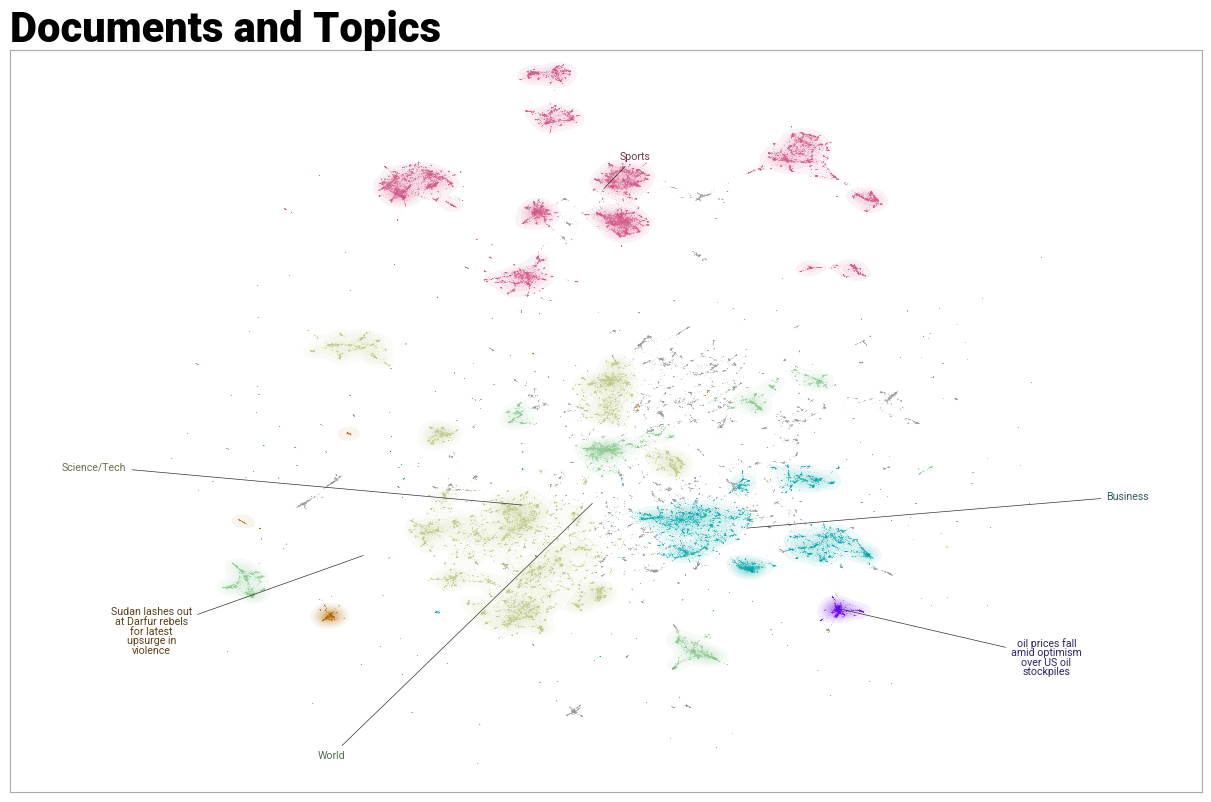

In [34]:
fig = topic_model.visualize_document_datamap(
    titles,
    topics=list(range(20)),
    reduced_embeddings=reduced_embeddings
)



## **BONUS**: Word Cloud

Make sure to pip install `wordcloud` first in order to follow this bonus:


First, we need to make sure that each topic is described by a bit more words than just 10 as that would make for a much more interesting wordcloud.

In [35]:
topic_model.update_topics(abstracts, top_n_words=500)

2025-07-30 12:50:39,760 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.


Then, we can run the following code to generate the wordcloud for our topic modeling topic:

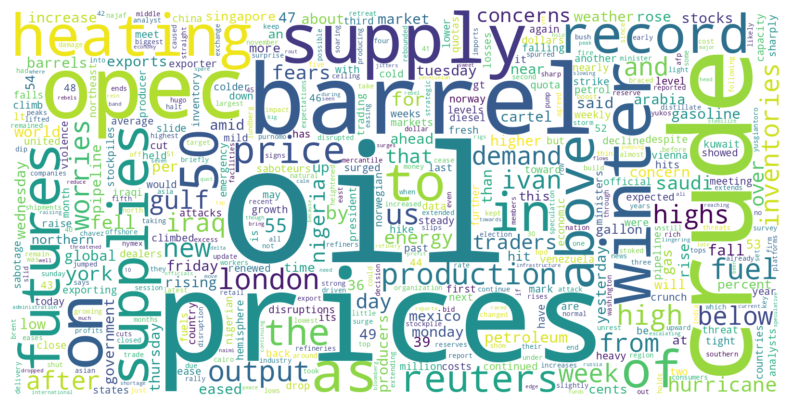

In [36]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    plt.figure(figsize=(10,5))
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000, width=1600, height=800)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=17)